In [1]:
from datasets import load_dataset

In [2]:
DATASET_NAME = 'roneneldan/TinyStories'
dataset = load_dataset(DATASET_NAME, split='train')
print('Total rows:', len(dataset))


Total rows: 2119719


In [3]:
# tokenize the dataset  
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True)
tokenized_datasets = dataset.map(tokenize_function, batched=True)


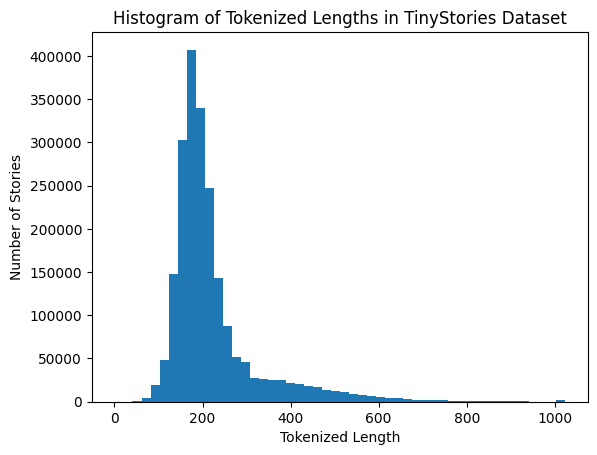

In [4]:
# Historgram of tokenized lengths
import matplotlib.pyplot as plt
lengths = [len(x) for x in tokenized_datasets['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title('Histogram of Tokenized Lengths in TinyStories Dataset')
plt.show()

In [5]:
for thresh in [64, 128, 256, 512]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.96645781822969% of stories are at least 64 tokens
95.51449979926585% of stories are at least 128 tokens
19.375209638636065% of stories are at least 256 tokens
3.174430195700468% of stories are at least 512 tokens


In [6]:
CHUNK_LENGTH = 128
def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map with batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset = chunk_dataset_with_map(tokenized_datasets, chunk_length=CHUNK_LENGTH)

Map:   0%|          | 0/2119719 [00:00<?, ? examples/s]

In [ ]:
for x in chunked_dataset['input_ids']:
    assert len(x) == CHUNK_LENGTH

In [ ]:
print(f"The chunked dataset is {len(chunked_dataset)/len(tokenized_datasets) * 100}% of the original dataset length")
total_tokens_chunked = len(chunked_dataset)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset = {total_tokens_chunked}M tokens")
print(f"We are left with {total_tokens_chunked/total_tokens_original * 100}% of the original tokens")

The chunked dataset is 128.07721212104056% of the original dataset length


NameError: name 'MIN_TOKENS' is not defined

In [ ]:
# Push the result to the hub
chunked_dataset.push_to_hub("TinyStories-chunked-128", private=True)